In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import gurobipy as gp
from gurobipy import GRB

In [2]:
cchp = -6.25
cbb = 2.47
cgb = 2.775
CAPchp = 2135
CAPbb = 995
CAPgb = 4800

In [22]:
ntypes = 3
nperiods = 24
maxstart0 = 1
nbuildings = 2
nhours = 1

generators = [1, 1, 3]
min_load = [750, 300, 1250]
max_load = [CAPchp, CAPbb, CAPgb]
base_cost = [1500, 741, 3462.5]
per_mw_cost = [cchp, cbb, cgb]
startup_cost = [0, 1235, 0]
base_carbon = [0, 0, 1250*0.215]
per_mw_carbon = [0, 0, 0.215]

demand = [[110, 200, 100, 100, 100, 3500, 3000, 3300, 1100, 1100, 3100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100],
          [110, 200, 100, 100, 100, 3500, 3100, 2500, 3100, 2000, 3100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100]]

In [23]:
model = gp.Model("HeatGeneration")

ngen = model.addVars(ntypes, nperiods, vtype=GRB.INTEGER, name="ngen")
nstart = model.addVars(ntypes, nperiods, vtype=GRB.INTEGER, name="nstart")
output = model.addVars(ntypes, nperiods, vtype=GRB.CONTINUOUS, name="genoutput")

storageout = model.addVars(nperiods, vtype=GRB.CONTINUOUS, name="storageout")
refill = model.addVars(nperiods, vtype=GRB.CONTINUOUS, name="refill")
storagelevel = model.addVars(nperiods, vtype=GRB.CONTINUOUS, name="storagelevel")

prdemand = model.addVars(nbuildings, nperiods, vtype=GRB.CONTINUOUS, name="prdemand")
exdemand = model.addVars(nbuildings, nperiods, vtype=GRB.CONTINUOUS, name="exdemand")
exdemand2 = model.addVars(nbuildings, nperiods, vtype=GRB.CONTINUOUS, name="exdemand2")
exdemand3 = model.addVars(nbuildings, nperiods, vtype=GRB.CONTINUOUS, name="exdemand3")
totalenergy = model.addVars(nperiods, vtype=GRB.CONTINUOUS, name="totalenergy")

In [24]:
gen = model.addConstrs(ngen[type, period] <= generators[type]
                         for type in range(ntypes) for period in range(nperiods))

In [25]:
min_output = model.addConstrs((output[type, period] >= min_load[type] * ngen[type, period])
                              for type in range(ntypes) for period in range(nperiods))

max_output = model.addConstrs((output[type, period] <= max_load[type] * ngen[type, period])
                              for type in range(ntypes) for period in range(nperiods))

In [26]:
total_demand = model.addConstrs(totalenergy[period] == gp.quicksum(prdemand[build, period] 
                            for build in range(nbuildings))
                               for period in range(nperiods))

In [27]:
predemand0 = model.addConstrs(prdemand[build, 0] == demand[build][0] + exdemand[build, 1] + exdemand2[build, 2] + exdemand3[build, 3]
                             for build in range(nbuildings))
predemand1 = model.addConstrs(prdemand[build, 1] == demand[build][0] - 0.995*exdemand[build, 0] + exdemand[build, 2] + exdemand2[build, 3] + exdemand3[build, 4]
                             for build in range(nbuildings))
predemand2 = model.addConstrs(prdemand[build, 2] == demand[build][0] - 0.995*exdemand[build, 0] - 0.99*exdemand2[build, 1] + exdemand[build, 3] + exdemand2[build, 4] + exdemand3[build, 5]
                             for build in range(nbuildings))
predemand = model.addConstrs(prdemand[build, period] == demand[build][period] - 0.995*exdemand[build, period-1] - 0.99*exdemand2[build, period-2] - 0.985*exdemand3[build, period-3] 
                             + exdemand[build, period+1] + exdemand2[build, period+2] + exdemand3[build, period+3]
                           for period in range(3,20) for build in range(nbuildings))
predemand21 = model.addConstrs(prdemand[build, 21] == demand[build][21] - 0.995*exdemand[build, 20] - 0.99*exdemand2[build, 19] - 0.985*exdemand3[build, 18] + exdemand[build, 22] + exdemand2[build, 23] 
                              for build in range(nbuildings))
predemand22 = model.addConstrs(prdemand[build, 22] == demand[build][22] - 0.995*exdemand[build, 21] - 0.99*exdemand2[build, 20] - 0.985*exdemand3[build, 19] + exdemand[build, 23]
                              for build in range(nbuildings))
predemand23 = model.addConstrs(prdemand[build, 23] == demand[build][23] - 0.995*exdemand[build, 22] - 0.99*exdemand2[build, 21] - 0.985*exdemand3[build, 20]
                              for build in range(nbuildings))

In [28]:
demand[0][8]

1100

In [29]:
meet_demand = model.addConstrs(gp.quicksum(output[type, period] for type in range(ntypes)) + 
                               storageout[period]
                               >= totalenergy[period] + refill[period]
                               for period in range(nperiods))

In [30]:
storage = model.addConstrs(storagelevel[period] == storagelevel[period-1] + refill[period] -
                             storageout[period]
                             for period in range(1,nperiods))

storage_max = model.addConstrs(storagelevel[period] <= 2300 for period in range(nperiods))

storage0 = model.addConstr(storagelevel[0] == storagelevel[nperiods-1] + refill[0] -
                             storageout[0])

In [31]:
startup0 = model.addConstrs((ngen[type,0] <= maxstart0 + nstart[type,0])
                            for type in range(ntypes))

startup = model.addConstrs((ngen[type,period] <= ngen[type,period-1] + nstart[type,period])
                           for type in range(ntypes) for period in range(1,nperiods))

In [32]:
active_money = gp.quicksum(base_cost[type]*ngen[type,period]
                    for type in range(ntypes) for period in range(nperiods))

per_mw_money = gp.quicksum(per_mw_cost[type]*(output[type,period] - min_load[type]*ngen[type,period])
                       for type in range(ntypes) for period in range(nperiods))

startup_obj_money = gp.quicksum(startup_cost[type]*nstart[type,period]
                         for type in range(ntypes) for period in range(nperiods))

model.setObjective(active_money + per_mw_money + startup_obj_money)

In [33]:
model.setParam(GRB.Param.Presolve, 0)
model.optimize()

Changed value of parameter Presolve to 0
   Prev: -1  Min: -1  Max: 2  Default: -1
Optimize a model with 430 rows, 504 columns and 1207 nonzeros
Variable types: 360 continuous, 144 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+03]
  Objective range  [1e-13, 6e+03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 4e+03]
Variable types: 360 continuous, 144 integer (0 binary)

Root relaxation: objective -1.717500e+05, 61 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0    -171750.0000 -171750.00  0.00%     -    0s

Explored 0 nodes (61 simplex iterations) in 0.20 seconds
Thread count was 8 (of 8 available processors)

Solution count 1: -171750 

Optimal solution found (tolerance 1.00e-04)
Best objective -1.717500000000e+05, best bound -1.717500000000e+05, gap 0.0000%


In [34]:
rows = ["totalenergy"]
totalenergytable = pd.DataFrame(columns=range(nperiods), index=rows, data=0.0)

for p in range(nperiods):
    totalenergytable.loc["totalenergy", p] = totalenergy[p].x
totalenergytable1 = totalenergytable.transpose()
totalenergytable1

,totalenergy
0,220.0
1,220.0
2,220.0
3,0.0
4,0.0
5,0.0
6,3100.0
7,1675.0
8,3100.0
9,2000.0


In [16]:
rows = ["Generators" + str(t) for t in range(ntypes)]
generatorstable = pd.DataFrame(columns=range(nperiods), index=rows, data=0.0)

for t in range(ntypes):
    for p in range(nperiods):
        generatorstable.loc["Generators"+str(t), p] = ngen[t,p].x
generatorstable1 = generatorstable.transpose()
generatorstable1

,Generators0,Generators1,Generators2
0,1.0,0.0,0.0
1,1.0,0.0,0.0
2,1.0,0.0,0.0
3,1.0,0.0,0.0
4,1.0,0.0,0.0
5,1.0,0.0,0.0
6,1.0,0.0,0.0
7,1.0,0.0,0.0
8,1.0,0.0,0.0
9,1.0,0.0,0.0


In [17]:
rows = ["Storagelevel"]
storagetable = pd.DataFrame(columns=range(nperiods), index=rows, data=0.0)


for p in range(nperiods):
        storagetable.loc["Storagelevel", p] = storagelevel[p].x
storagetable1 = storagetable.transpose()
storagetable1

,Storagelevel
0,0.0
1,0.0
2,0.0
3,0.0
4,165.0
5,2300.0
6,365.0
7,2300.0
8,365.0
9,2300.0


In [18]:
rows = ["exdemand" + str(b) for b in range(nbuildings)]
exdemandtable = pd.DataFrame(columns=range(nperiods), index=rows, data=0.0)

for b in range(nbuildings):
    for p in range(nperiods):
        exdemandtable.loc["exdemand"+str(b), p] = exdemand[b,p].x
exdemandtable1 = exdemandtable.transpose()
exdemandtable1

,exdemand0,exdemand1
0,0.000000,0.000000
1,0.000000,0.000000
2,0.000000,0.000000
3,0.000000,0.000000
4,0.000000,0.000000
5,943.127039,0.000000
6,0.000000,0.000000
7,908.411404,0.000000
8,0.000000,0.000000
9,1773.869347,0.000000


In [35]:
rows = ["prdemand" + str(b) for b in range(nbuildings)]
prdemandtable = pd.DataFrame(columns=range(nperiods), index=rows, data=0.0)

for b in range(nbuildings):
    for p in range(nperiods):
        prdemandtable.loc["prdemand"+str(b), p] = prdemand[b,p].x
prdemandtable1 = prdemandtable.transpose()
prdemandtable1

,prdemand0,prdemand1
0,110.0,110.0
1,110.0,110.0
2,110.0,110.0
3,0.0,0.0
4,0.0,0.0
5,0.0,0.0
6,0.0,3100.0
7,0.0,1675.0
8,0.0,3100.0
9,0.0,2000.0


In [36]:
demand[0][1]

200

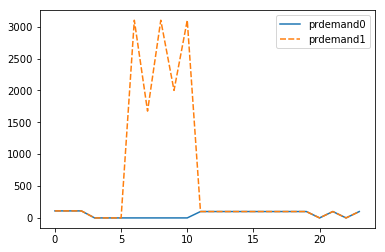

In [37]:
sns.lineplot(data=prdemandtable1 )

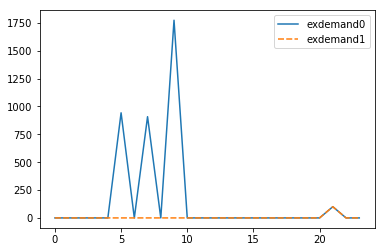

In [38]:
sns.lineplot(data=exdemandtable1 )